# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            #nn.LayerNorm(hidden1_size),
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            #nn.LayerNorm(hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            #nn.LayerNorm(hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=200, bias=True)
    (2): Tanh()
    (3): Linear(in_features=200, out_features=200, bias=True)
    (4): Tanh()
    (5): Linear(in_features=200, out_features=200, bias=True)
    (6): Tanh()
    (7): Linear(in_features=200, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# #Normalisieren der Tensoren
# x_input = norm(x_input, p=1, dim = 1)
# y_output = norm(y_output, p=1, dim = 0)

# Tensoren zu einem großen Set gruppieren
dataset = TensorDataset(x_input, y_output)

# for x,y in dataset:
#     print(x)
#     print(y)
    
# Split in Trainings und Test Set
train_dataset, test_dataset = random_split(dataset, 
                                           [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
                                           generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 2)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred, y)

            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if (pred[i,0] - y[i,0] and pred[i,1] - y[i,1]) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f} \n")

    net.train()
    
    return acc, loss, MRE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)

Epoch 1/200, Iteration 1/12, Loss: 0.3174
Epoch 1/200, Iteration 2/12, Loss: 1.1539
Epoch 1/200, Iteration 3/12, Loss: 1.6442
Epoch 1/200, Iteration 4/12, Loss: 1.1497
Epoch 1/200, Iteration 5/12, Loss: 0.4913
Epoch 1/200, Iteration 6/12, Loss: 0.4470
Epoch 1/200, Iteration 7/12, Loss: 0.6947
Epoch 1/200, Iteration 8/12, Loss: 0.4094
Epoch 1/200, Iteration 9/12, Loss: 0.2419
Epoch 1/200, Iteration 10/12, Loss: 0.2281
Epoch 1/200, Iteration 11/12, Loss: 0.3510
Epoch 1/200, Iteration 12/12, Loss: 0.3194
Epoch 1/200, Iteration 13/12, Loss: 0.2918
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.297875, MRE: 1.506739 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.291250, MRE: 1.396217 

Epoch 2/200, Iteration 1/12, Loss: 0.2178
Epoch 2/200, Iteration 2/12, Loss: 0.2008
Epoch 2/200, Iteration 3/12, Loss: 0.1704
Epoch 2/200, Iteration 4/12, Loss: 0.2147
Epoch 2/200, Iteration 5/12, Loss: 0.1620
Epoch 2/200, Iteration 6/12, Loss: 0.1847
Epoch 2/200, Iteration 7/12, Loss: 0.1542
Epoch 2/200, Iterat

Train Error: 
 Accuracy: 70.75%, Avg loss: 0.046892, MRE: 0.278113 

Test Error: 
 Accuracy: 67.0%, Avg loss: 0.047687, MRE: 0.260614 

Epoch 14/200, Iteration 1/12, Loss: 0.0527
Epoch 14/200, Iteration 2/12, Loss: 0.0670
Epoch 14/200, Iteration 3/12, Loss: 0.0594
Epoch 14/200, Iteration 4/12, Loss: 0.0440
Epoch 14/200, Iteration 5/12, Loss: 0.0534
Epoch 14/200, Iteration 6/12, Loss: 0.0449
Epoch 14/200, Iteration 7/12, Loss: 0.0373
Epoch 14/200, Iteration 8/12, Loss: 0.0449
Epoch 14/200, Iteration 9/12, Loss: 0.0415
Epoch 14/200, Iteration 10/12, Loss: 0.0524
Epoch 14/200, Iteration 11/12, Loss: 0.0519
Epoch 14/200, Iteration 12/12, Loss: 0.0513
Epoch 14/200, Iteration 13/12, Loss: 0.0398
Train Error: 
 Accuracy: 42.88%, Avg loss: 0.035823, MRE: 0.318274 

Test Error: 
 Accuracy: 46.0%, Avg loss: 0.037383, MRE: 0.283408 

Epoch 15/200, Iteration 1/12, Loss: 0.0442
Epoch 15/200, Iteration 2/12, Loss: 0.0400
Epoch 15/200, Iteration 3/12, Loss: 0.0485
Epoch 15/200, Iteration 4/12, Loss: 

Epoch 26/200, Iteration 1/12, Loss: 0.0461
Epoch 26/200, Iteration 2/12, Loss: 0.0547
Epoch 26/200, Iteration 3/12, Loss: 0.0612
Epoch 26/200, Iteration 4/12, Loss: 0.0389
Epoch 26/200, Iteration 5/12, Loss: 0.0415
Epoch 26/200, Iteration 6/12, Loss: 0.0322
Epoch 26/200, Iteration 7/12, Loss: 0.0279
Epoch 26/200, Iteration 8/12, Loss: 0.0381
Epoch 26/200, Iteration 9/12, Loss: 0.0467
Epoch 26/200, Iteration 10/12, Loss: 0.0484
Epoch 26/200, Iteration 11/12, Loss: 0.0463
Epoch 26/200, Iteration 12/12, Loss: 0.0460
Epoch 26/200, Iteration 13/12, Loss: 0.0257
Train Error: 
 Accuracy: 86.62%, Avg loss: 0.029520, MRE: 0.198199 

Test Error: 
 Accuracy: 85.5%, Avg loss: 0.028015, MRE: 0.170036 

Epoch 27/200, Iteration 1/12, Loss: 0.0263
Epoch 27/200, Iteration 2/12, Loss: 0.0470
Epoch 27/200, Iteration 3/12, Loss: 0.0292
Epoch 27/200, Iteration 4/12, Loss: 0.0326
Epoch 27/200, Iteration 5/12, Loss: 0.0255
Epoch 27/200, Iteration 6/12, Loss: 0.0353
Epoch 27/200, Iteration 7/12, Loss: 0.0424


Train Error: 
 Accuracy: 67.5%, Avg loss: 0.025440, MRE: 0.151812 

Test Error: 
 Accuracy: 69.0%, Avg loss: 0.024202, MRE: 0.146440 

Epoch 39/200, Iteration 1/12, Loss: 0.0291
Epoch 39/200, Iteration 2/12, Loss: 0.0278
Epoch 39/200, Iteration 3/12, Loss: 0.0213
Epoch 39/200, Iteration 4/12, Loss: 0.0301
Epoch 39/200, Iteration 5/12, Loss: 0.0448
Epoch 39/200, Iteration 6/12, Loss: 0.0400
Epoch 39/200, Iteration 7/12, Loss: 0.0272
Epoch 39/200, Iteration 8/12, Loss: 0.0279
Epoch 39/200, Iteration 9/12, Loss: 0.0397
Epoch 39/200, Iteration 10/12, Loss: 0.0332
Epoch 39/200, Iteration 11/12, Loss: 0.0256
Epoch 39/200, Iteration 12/12, Loss: 0.0469
Epoch 39/200, Iteration 13/12, Loss: 0.0419
Train Error: 
 Accuracy: 95.62%, Avg loss: 0.045318, MRE: 0.243328 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.046109, MRE: 0.231659 

Epoch 40/200, Iteration 1/12, Loss: 0.0539
Epoch 40/200, Iteration 2/12, Loss: 0.0726
Epoch 40/200, Iteration 3/12, Loss: 0.0312
Epoch 40/200, Iteration 4/12, Loss: 0

Train Error: 
 Accuracy: 76.88%, Avg loss: 0.011014, MRE: 0.090628 

Test Error: 
 Accuracy: 80.0%, Avg loss: 0.011467, MRE: 0.076238 

Epoch 52/200, Iteration 1/12, Loss: 0.0121
Epoch 52/200, Iteration 2/12, Loss: 0.0227
Epoch 52/200, Iteration 3/12, Loss: 0.0152
Epoch 52/200, Iteration 4/12, Loss: 0.0148
Epoch 52/200, Iteration 5/12, Loss: 0.0143
Epoch 52/200, Iteration 6/12, Loss: 0.0191
Epoch 52/200, Iteration 7/12, Loss: 0.0112
Epoch 52/200, Iteration 8/12, Loss: 0.0190
Epoch 52/200, Iteration 9/12, Loss: 0.0194
Epoch 52/200, Iteration 10/12, Loss: 0.0188
Epoch 52/200, Iteration 11/12, Loss: 0.0122
Epoch 52/200, Iteration 12/12, Loss: 0.0111
Epoch 52/200, Iteration 13/12, Loss: 0.0158
Train Error: 
 Accuracy: 57.0%, Avg loss: 0.010027, MRE: 0.070944 

Test Error: 
 Accuracy: 54.0%, Avg loss: 0.010110, MRE: 0.062188 

Epoch 53/200, Iteration 1/12, Loss: 0.0142
Epoch 53/200, Iteration 2/12, Loss: 0.0146
Epoch 53/200, Iteration 3/12, Loss: 0.0167
Epoch 53/200, Iteration 4/12, Loss: 0

Epoch 63/200, Iteration 12/12, Loss: 0.0282
Epoch 63/200, Iteration 13/12, Loss: 0.0171
Train Error: 
 Accuracy: 92.5%, Avg loss: 0.011444, MRE: 0.078390 

Test Error: 
 Accuracy: 91.0%, Avg loss: 0.012550, MRE: 0.072854 

Epoch 64/200, Iteration 1/12, Loss: 0.0078
Epoch 64/200, Iteration 2/12, Loss: 0.0107
Epoch 64/200, Iteration 3/12, Loss: 0.0167
Epoch 64/200, Iteration 4/12, Loss: 0.0199
Epoch 64/200, Iteration 5/12, Loss: 0.0157
Epoch 64/200, Iteration 6/12, Loss: 0.0191
Epoch 64/200, Iteration 7/12, Loss: 0.0218
Epoch 64/200, Iteration 8/12, Loss: 0.0184
Epoch 64/200, Iteration 9/12, Loss: 0.0121
Epoch 64/200, Iteration 10/12, Loss: 0.0150
Epoch 64/200, Iteration 11/12, Loss: 0.0315
Epoch 64/200, Iteration 12/12, Loss: 0.0226
Epoch 64/200, Iteration 13/12, Loss: 0.0189
Train Error: 
 Accuracy: 96.12%, Avg loss: 0.011183, MRE: 0.064546 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.012946, MRE: 0.077221 

Epoch 65/200, Iteration 1/12, Loss: 0.0176
Epoch 65/200, Iteration 2/12, Loss:

Epoch 75/200, Iteration 11/12, Loss: 0.0172
Epoch 75/200, Iteration 12/12, Loss: 0.0186
Epoch 75/200, Iteration 13/12, Loss: 0.0200
Train Error: 
 Accuracy: 93.88%, Avg loss: 0.005588, MRE: 0.036226 

Test Error: 
 Accuracy: 91.0%, Avg loss: 0.006279, MRE: 0.034349 

Epoch 76/200, Iteration 1/12, Loss: 0.0189
Epoch 76/200, Iteration 2/12, Loss: 0.0163
Epoch 76/200, Iteration 3/12, Loss: 0.0145
Epoch 76/200, Iteration 4/12, Loss: 0.0087
Epoch 76/200, Iteration 5/12, Loss: 0.0104
Epoch 76/200, Iteration 6/12, Loss: 0.0189
Epoch 76/200, Iteration 7/12, Loss: 0.0123
Epoch 76/200, Iteration 8/12, Loss: 0.0163
Epoch 76/200, Iteration 9/12, Loss: 0.0084
Epoch 76/200, Iteration 10/12, Loss: 0.0092
Epoch 76/200, Iteration 11/12, Loss: 0.0222
Epoch 76/200, Iteration 12/12, Loss: 0.0146
Epoch 76/200, Iteration 13/12, Loss: 0.0152
Train Error: 
 Accuracy: 92.62%, Avg loss: 0.005720, MRE: 0.034145 

Test Error: 
 Accuracy: 91.0%, Avg loss: 0.006224, MRE: 0.033062 

Epoch 77/200, Iteration 1/12, Los

Epoch 87/200, Iteration 8/12, Loss: 0.0251
Epoch 87/200, Iteration 9/12, Loss: 0.0159
Epoch 87/200, Iteration 10/12, Loss: 0.0179
Epoch 87/200, Iteration 11/12, Loss: 0.0241
Epoch 87/200, Iteration 12/12, Loss: 0.0074
Epoch 87/200, Iteration 13/12, Loss: 0.0196
Train Error: 
 Accuracy: 96.88%, Avg loss: 0.006776, MRE: 0.036537 

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.007070, MRE: 0.034505 

Epoch 88/200, Iteration 1/12, Loss: 0.0150
Epoch 88/200, Iteration 2/12, Loss: 0.0088
Epoch 88/200, Iteration 3/12, Loss: 0.0152
Epoch 88/200, Iteration 4/12, Loss: 0.0131
Epoch 88/200, Iteration 5/12, Loss: 0.0125
Epoch 88/200, Iteration 6/12, Loss: 0.0190
Epoch 88/200, Iteration 7/12, Loss: 0.0078
Epoch 88/200, Iteration 8/12, Loss: 0.0261
Epoch 88/200, Iteration 9/12, Loss: 0.0163
Epoch 88/200, Iteration 10/12, Loss: 0.0154
Epoch 88/200, Iteration 11/12, Loss: 0.0216
Epoch 88/200, Iteration 12/12, Loss: 0.0150
Epoch 88/200, Iteration 13/12, Loss: 0.0246
Train Error: 
 Accuracy: 94.62%, Avg lo

Epoch 100/200, Iteration 11/12, Loss: 0.0203
Epoch 100/200, Iteration 12/12, Loss: 0.0212
Epoch 100/200, Iteration 13/12, Loss: 0.0205
Train Error: 
 Accuracy: 97.38%, Avg loss: 0.005863, MRE: 0.034733 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.006849, MRE: 0.039879 

Epoch 101/200, Iteration 1/12, Loss: 0.0122
Epoch 101/200, Iteration 2/12, Loss: 0.0156
Epoch 101/200, Iteration 3/12, Loss: 0.0150
Epoch 101/200, Iteration 4/12, Loss: 0.0142
Epoch 101/200, Iteration 5/12, Loss: 0.0223
Epoch 101/200, Iteration 6/12, Loss: 0.0129
Epoch 101/200, Iteration 7/12, Loss: 0.0230
Epoch 101/200, Iteration 8/12, Loss: 0.0209
Epoch 101/200, Iteration 9/12, Loss: 0.0117
Epoch 101/200, Iteration 10/12, Loss: 0.0135
Epoch 101/200, Iteration 11/12, Loss: 0.0267
Epoch 101/200, Iteration 12/12, Loss: 0.0123
Epoch 101/200, Iteration 13/12, Loss: 0.0190
Train Error: 
 Accuracy: 90.38%, Avg loss: 0.005996, MRE: 0.033835 

Test Error: 
 Accuracy: 89.0%, Avg loss: 0.006534, MRE: 0.034481 

Epoch 102/200, It

Train Error: 
 Accuracy: 95.38%, Avg loss: 0.005091, MRE: 0.029763 

Test Error: 
 Accuracy: 93.0%, Avg loss: 0.005507, MRE: 0.029598 

Epoch 113/200, Iteration 1/12, Loss: 0.0088
Epoch 113/200, Iteration 2/12, Loss: 0.0097
Epoch 113/200, Iteration 3/12, Loss: 0.0112
Epoch 113/200, Iteration 4/12, Loss: 0.0090
Epoch 113/200, Iteration 5/12, Loss: 0.0122
Epoch 113/200, Iteration 6/12, Loss: 0.0171
Epoch 113/200, Iteration 7/12, Loss: 0.0371
Epoch 113/200, Iteration 8/12, Loss: 0.0089
Epoch 113/200, Iteration 9/12, Loss: 0.0099
Epoch 113/200, Iteration 10/12, Loss: 0.0170
Epoch 113/200, Iteration 11/12, Loss: 0.0132
Epoch 113/200, Iteration 12/12, Loss: 0.0159
Epoch 113/200, Iteration 13/12, Loss: 0.0203
Train Error: 
 Accuracy: 97.12%, Avg loss: 0.005242, MRE: 0.032227 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.005725, MRE: 0.032237 

Epoch 114/200, Iteration 1/12, Loss: 0.0179
Epoch 114/200, Iteration 2/12, Loss: 0.0077
Epoch 114/200, Iteration 3/12, Loss: 0.0177
Epoch 114/200, Itera

Train Error: 
 Accuracy: 96.75%, Avg loss: 0.005052, MRE: 0.029246 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.005667, MRE: 0.030146 

Epoch 125/200, Iteration 1/12, Loss: 0.0198
Epoch 125/200, Iteration 2/12, Loss: 0.0211
Epoch 125/200, Iteration 3/12, Loss: 0.0065
Epoch 125/200, Iteration 4/12, Loss: 0.0147
Epoch 125/200, Iteration 5/12, Loss: 0.0075
Epoch 125/200, Iteration 6/12, Loss: 0.0245
Epoch 125/200, Iteration 7/12, Loss: 0.0112
Epoch 125/200, Iteration 8/12, Loss: 0.0111
Epoch 125/200, Iteration 9/12, Loss: 0.0079
Epoch 125/200, Iteration 10/12, Loss: 0.0118
Epoch 125/200, Iteration 11/12, Loss: 0.0088
Epoch 125/200, Iteration 12/12, Loss: 0.0103
Epoch 125/200, Iteration 13/12, Loss: 0.0062
Train Error: 
 Accuracy: 96.88%, Avg loss: 0.004842, MRE: 0.029163 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.005534, MRE: 0.029483 

Epoch 126/200, Iteration 1/12, Loss: 0.0197
Epoch 126/200, Iteration 2/12, Loss: 0.0213
Epoch 126/200, Iteration 3/12, Loss: 0.0119
Epoch 126/200, Itera

Train Error: 
 Accuracy: 96.25%, Avg loss: 0.004758, MRE: 0.028601 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.005544, MRE: 0.029941 

Epoch 138/200, Iteration 1/12, Loss: 0.0085
Epoch 138/200, Iteration 2/12, Loss: 0.0113
Epoch 138/200, Iteration 3/12, Loss: 0.0152
Epoch 138/200, Iteration 4/12, Loss: 0.0082
Epoch 138/200, Iteration 5/12, Loss: 0.0092
Epoch 138/200, Iteration 6/12, Loss: 0.0103
Epoch 138/200, Iteration 7/12, Loss: 0.0093
Epoch 138/200, Iteration 8/12, Loss: 0.0140
Epoch 138/200, Iteration 9/12, Loss: 0.0108
Epoch 138/200, Iteration 10/12, Loss: 0.0126
Epoch 138/200, Iteration 11/12, Loss: 0.0116
Epoch 138/200, Iteration 12/12, Loss: 0.0210
Epoch 138/200, Iteration 13/12, Loss: 0.0204
Train Error: 
 Accuracy: 96.62%, Avg loss: 0.004895, MRE: 0.029940 

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.005710, MRE: 0.030646 

Epoch 139/200, Iteration 1/12, Loss: 0.0088
Epoch 139/200, Iteration 2/12, Loss: 0.0095
Epoch 139/200, Iteration 3/12, Loss: 0.0130
Epoch 139/200, Itera

Epoch 150/200, Iteration 13/12, Loss: 0.0130
Train Error: 
 Accuracy: 96.12%, Avg loss: 0.004688, MRE: 0.028303 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.005509, MRE: 0.029437 

Epoch 151/200, Iteration 1/12, Loss: 0.0279
Epoch 151/200, Iteration 2/12, Loss: 0.0144
Epoch 151/200, Iteration 3/12, Loss: 0.0119
Epoch 151/200, Iteration 4/12, Loss: 0.0083
Epoch 151/200, Iteration 5/12, Loss: 0.0180
Epoch 151/200, Iteration 6/12, Loss: 0.0070
Epoch 151/200, Iteration 7/12, Loss: 0.0107
Epoch 151/200, Iteration 8/12, Loss: 0.0105
Epoch 151/200, Iteration 9/12, Loss: 0.0336
Epoch 151/200, Iteration 10/12, Loss: 0.0089
Epoch 151/200, Iteration 11/12, Loss: 0.0095
Epoch 151/200, Iteration 12/12, Loss: 0.0137
Epoch 151/200, Iteration 13/12, Loss: 0.0163
Train Error: 
 Accuracy: 96.62%, Avg loss: 0.004831, MRE: 0.029359 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.005612, MRE: 0.030044 

Epoch 152/200, Iteration 1/12, Loss: 0.0113
Epoch 152/200, Iteration 2/12, Loss: 0.0057
Epoch 152/200, Iter

Train Error: 
 Accuracy: 95.5%, Avg loss: 0.005039, MRE: 0.029871 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.005637, MRE: 0.029706 

Epoch 164/200, Iteration 1/12, Loss: 0.0109
Epoch 164/200, Iteration 2/12, Loss: 0.0094
Epoch 164/200, Iteration 3/12, Loss: 0.0151
Epoch 164/200, Iteration 4/12, Loss: 0.0191
Epoch 164/200, Iteration 5/12, Loss: 0.0084
Epoch 164/200, Iteration 6/12, Loss: 0.0169
Epoch 164/200, Iteration 7/12, Loss: 0.0227
Epoch 164/200, Iteration 8/12, Loss: 0.0161
Epoch 164/200, Iteration 9/12, Loss: 0.0145
Epoch 164/200, Iteration 10/12, Loss: 0.0078
Epoch 164/200, Iteration 11/12, Loss: 0.0219
Epoch 164/200, Iteration 12/12, Loss: 0.0306
Epoch 164/200, Iteration 13/12, Loss: 0.0302
Train Error: 
 Accuracy: 95.25%, Avg loss: 0.004817, MRE: 0.028940 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.005591, MRE: 0.029604 

Epoch 165/200, Iteration 1/12, Loss: 0.0118
Epoch 165/200, Iteration 2/12, Loss: 0.0235
Epoch 165/200, Iteration 3/12, Loss: 0.0168
Epoch 165/200, Iterat

Train Error: 
 Accuracy: 96.88%, Avg loss: 0.004966, MRE: 0.029895 

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.005824, MRE: 0.030712 

Epoch 176/200, Iteration 1/12, Loss: 0.0167
Epoch 176/200, Iteration 2/12, Loss: 0.0149
Epoch 176/200, Iteration 3/12, Loss: 0.0148
Epoch 176/200, Iteration 4/12, Loss: 0.0192
Epoch 176/200, Iteration 5/12, Loss: 0.0156
Epoch 176/200, Iteration 6/12, Loss: 0.0172
Epoch 176/200, Iteration 7/12, Loss: 0.0055
Epoch 176/200, Iteration 8/12, Loss: 0.0058
Epoch 176/200, Iteration 9/12, Loss: 0.0182
Epoch 176/200, Iteration 10/12, Loss: 0.0217
Epoch 176/200, Iteration 11/12, Loss: 0.0193
Epoch 176/200, Iteration 12/12, Loss: 0.0115
Epoch 176/200, Iteration 13/12, Loss: 0.0221
Train Error: 
 Accuracy: 96.75%, Avg loss: 0.005132, MRE: 0.029497 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.005816, MRE: 0.030528 

Epoch 177/200, Iteration 1/12, Loss: 0.0142
Epoch 177/200, Iteration 2/12, Loss: 0.0109
Epoch 177/200, Iteration 3/12, Loss: 0.0159
Epoch 177/200, Itera

Epoch 188/200, Iteration 12/12, Loss: 0.0199
Epoch 188/200, Iteration 13/12, Loss: 0.0201
Train Error: 
 Accuracy: 97.0%, Avg loss: 0.004673, MRE: 0.028410 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.005451, MRE: 0.029448 

Epoch 189/200, Iteration 1/12, Loss: 0.0189
Epoch 189/200, Iteration 2/12, Loss: 0.0105
Epoch 189/200, Iteration 3/12, Loss: 0.0129
Epoch 189/200, Iteration 4/12, Loss: 0.0186
Epoch 189/200, Iteration 5/12, Loss: 0.0251
Epoch 189/200, Iteration 6/12, Loss: 0.0169
Epoch 189/200, Iteration 7/12, Loss: 0.0115
Epoch 189/200, Iteration 8/12, Loss: 0.0129
Epoch 189/200, Iteration 9/12, Loss: 0.0169
Epoch 189/200, Iteration 10/12, Loss: 0.0162
Epoch 189/200, Iteration 11/12, Loss: 0.0109
Epoch 189/200, Iteration 12/12, Loss: 0.0098
Epoch 189/200, Iteration 13/12, Loss: 0.0079
Train Error: 
 Accuracy: 96.62%, Avg loss: 0.004711, MRE: 0.028610 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.005501, MRE: 0.029267 

Epoch 190/200, Iteration 1/12, Loss: 0.0181
Epoch 190/200, Iter

#### Plots loss vs Epoch

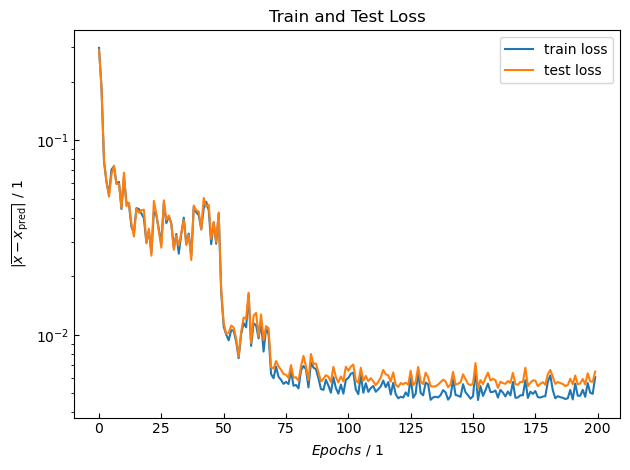

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '|$\overline{x - x\mathregular{_{pred}}}$| / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2(H2) = 0.9874216374097596 , R^2(NH3) = 0.9771812819208521
Test Dataset: R^2(H2) = 0.9853495538676006 , R^2(NH3) = 0.9694689049389817
Max Error Training: |x_H2 - x_H2,pred| = 0.08949281238830398 , |x_NH3 - x_NH3,pred| = 0.058975177799820144
Max Error Test: |x_H2 - x_H2,pred| = 0.10274575299626032 , |x_NH3 - x_NH3,pred| = 0.0717251907582924


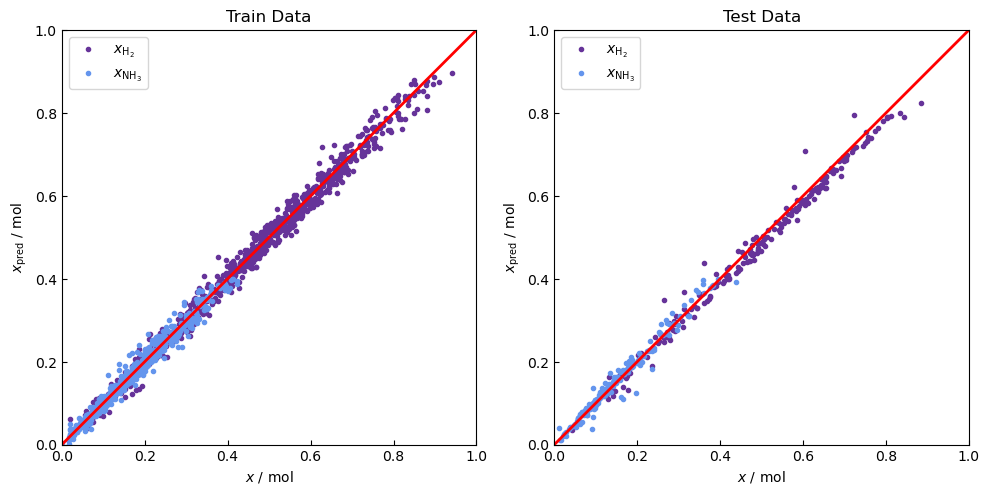

In [21]:
x_H2_real = []
x_H2_pred = []
x_NH3_real = []
x_NH3_pred = []
for (X,y) in train_dataloader:
    x_H2_real = np.append(x_H2_real, y[:,0].numpy())
    x_NH3_real = np.append(x_NH3_real, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred = np.append(x_H2_pred, help_x_H2)
    x_NH3_pred = np.append(x_NH3_pred, help_x_NH3)

x_H2_real_test = []
x_H2_pred_test = []
x_NH3_real_test = []
x_NH3_pred_test = []
for (X,y) in test_dataloader:
    x_H2_real_test = np.append(x_H2_real_test, y[:,0].numpy())
    x_NH3_real_test = np.append(x_NH3_real_test, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test = np.append(x_H2_pred_test, help_x_H2)
    x_NH3_pred_test = np.append(x_NH3_pred_test, help_x_NH3)

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].set(xlabel = '$x$ / mol', ylabel = '$x\mathregular{_{pred}}$ / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].set(xlabel = '$x$ / mol', ylabel = '$x\mathregular{_{pred}}$ / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

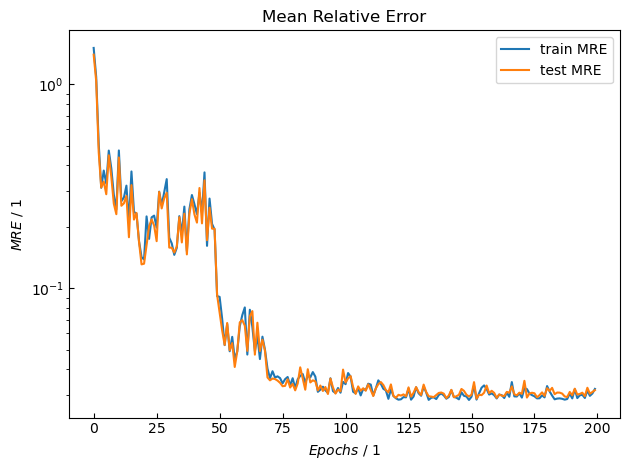

In [12]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_MRE, label='train MRE')
ax.semilogy(test_MRE, label='test MRE')
plt.title("Mean Relative Error")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

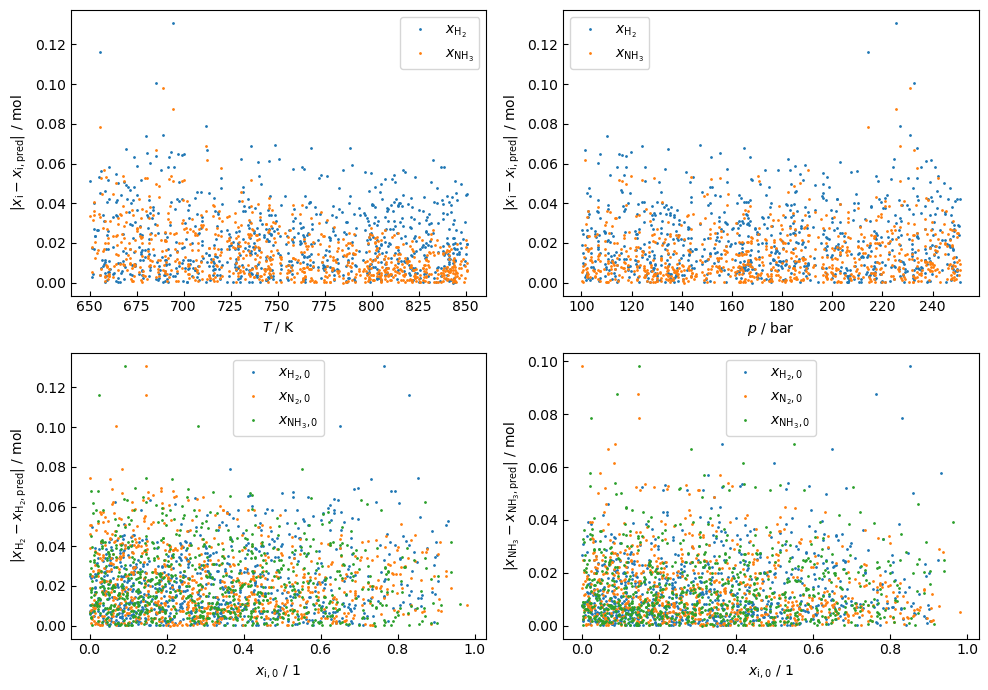

In [13]:
mistake_H2 = []
mistake_NH3 = []
param_T = []
param_p = []
param_x_H2_0 = []
param_x_N2_0 = []
param_x_NH3_0 = []
for X,y in train_dataloader:
    help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
    mistake_H2 = np.append(mistake_H2, help_mistake_H2)
    mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3)
    param_T = np.append(param_T, X[:,0])
    param_p = np.append(param_p, X[:,1])
    param_x_H2_0 = np.append(param_x_H2_0, X[:,2])
    param_x_N2_0 = np.append(param_x_N2_0, X[:,3])
    param_x_NH3_0 = np.append(param_x_NH3_0, X[:,4])

# train_parameters, train_xi = next(iter(train_dataloader))
# y = abs(train_xi - net(train_parameters).detach().numpy())
# #[T, p ,x_H2, x_N2, x_NH3]
# x = [train_parameters[:,0], train_parameters[:,1], train_parameters[:,2], train_parameters[:,3], train_parameters[:,4]]

# print(param_T[0])
# print(param_T)
# print(mistake)

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].plot(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].plot(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].plot(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].plot(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].plot(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].plot(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].plot(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].legend()

ax[1,1].plot(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].plot(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].plot(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].legend()

plt.tight_layout()
plt.show()

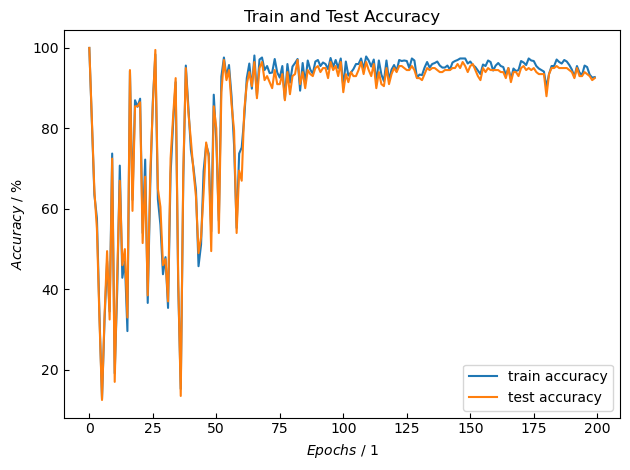

In [14]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [15]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[7.6026e+02, 1.1186e+02, 1.4236e-02, 9.8110e-01, 4.6626e-03],
        [6.9332e+02, 1.2508e+02, 8.2865e-01, 1.0397e-01, 6.7384e-02],
        [8.2275e+02, 1.3806e+02, 4.2911e-01, 5.6398e-01, 6.9056e-03],
        [6.7825e+02, 1.6132e+02, 1.1015e-01, 4.6369e-01, 4.2616e-01],
        [8.0550e+02, 2.4971e+02, 3.0865e-02, 3.0290e-02, 9.3884e-01],
        [7.2602e+02, 2.1077e+02, 3.9702e-01, 2.5228e-01, 3.5070e-01],
        [8.3384e+02, 2.1403e+02, 1.1333e-01, 2.5842e-01, 6.2825e-01],
        [7.9787e+02, 1.3023e+02, 7.8699e-02, 3.6526e-01, 5.5604e-01],
        [8.0712e+02, 1.3770e+02, 5.6118e-02, 6.8454e-01, 2.5934e-01],
        [7.6254e+02, 2.0200e+02, 1.1523e-01, 4.2622e-01, 4.5855e-01],
        [6.9019e+02, 1.3796e+02, 9.4526e-02, 1.8455e-01, 7.2092e-01],
        [8.0064e+02, 2.3524e+02, 1.9616e-01, 1.6062e-01, 6.4322e-01],
        [7.8498e+02, 1.3152e+02, 7.1084e-02, 5.5325e-01, 3.7566e-01],
        [8.0257e+02, 1.6699e+02, 3.9575e-02, 4.0234e-01, 5.5808e-01],
        [7.9879e+02,

#### Einblick in Netzwerk

In [16]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([0.6944, 0.6255, 0.6603, 0.8134, 0.7264], requires_grad=True),
 Parameter containing:
 tensor([ 0.1345,  0.0051, -0.1362,  0.0947, -0.0147], requires_grad=True),
 Parameter containing:
 tensor([[-7.2732e-02, -1.3150e-01, -1.7958e-01, -1.9339e-01, -1.2637e-01],
         [-2.8187e-01,  2.1597e-02, -6.0384e-02,  9.2108e-02,  3.5387e-01],
         [-6.6799e-02, -2.4780e-01, -1.7574e-01, -1.6559e-01,  1.1662e-01],
         [-5.7052e-02,  3.0053e-01, -8.9198e-02,  3.1154e-01, -9.2004e-02],
         [ 1.2875e-01,  1.1933e-01,  6.8681e-02, -1.8569e-02, -9.3126e-02],
         [-2.3820e-06,  4.0436e-02, -2.4032e-01, -2.6603e-01, -3.0055e-01],
         [-2.9951e-02,  1.7966e-01, -1.9426e-01,  2.5670e-01, -5.6174e-02],
         [-3.4390e-01, -2.5862e-01, -8.2263e-02, -3.3242e-01,  2.4553e-01],
         [-1.5868e-01, -3.7015e-01, -4.6454e-02,  1.5536e-03,  2.3931e-01],
         [-2.3614e-03, -4.9080e-03, -3.4004e-01, -2.8955e-01, -3.2691e-01],
         [-2.5803e-01,  

In [17]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.1321, 0.1869, 0.6353, 0.8267, 0.7623],
        [0.3640, 0.1019, 0.2767, 0.2437, 0.3994]])
tensor([[ 0.3860,  0.2461],
        [ 0.4160, -0.1009]], grad_fn=<AddmmBackward0>)


In [18]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [19]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[7.5586e+02, 1.6486e+02, 5.0538e-01, 3.6624e-01, 1.2838e-01],
        [7.4759e+02, 2.0615e+02, 3.3036e-01, 1.2852e-01, 5.4112e-01],
        [8.1628e+02, 1.6620e+02, 7.8720e-02, 7.9061e-01, 1.3067e-01],
        [6.9997e+02, 2.4713e+02, 1.2397e-01, 5.0414e-01, 3.7189e-01],
        [8.1355e+02, 1.5385e+02, 8.1097e-02, 2.3549e-01, 6.8342e-01],
        [7.5574e+02, 1.8042e+02, 1.0842e-01, 4.0676e-03, 8.8751e-01],
        [6.5826e+02, 1.6710e+02, 1.6854e-01, 5.0092e-01, 3.3053e-01],
        [8.2163e+02, 2.2289e+02, 2.6394e-01, 2.4911e-01, 4.8695e-01],
        [6.9578e+02, 2.0526e+02, 7.1874e-02, 5.0907e-01, 4.1905e-01],
        [7.8009e+02, 2.1484e+02, 3.6390e-01, 2.7521e-01, 3.6089e-01],
        [6.5971e+02, 2.1653e+02, 1.1607e-01, 1.1307e-01, 7.7087e-01],
        [8.1404e+02, 1.5292e+02, 2.0242e-01, 3.0832e-01, 4.8926e-01],
        [7.5181e+02, 1.0961e+02, 6.3794e-01, 1.8156e-01, 1.8050e-01],
        [6.6492e+02, 2.0621e+02, 4.1133e-01, 5.6798e-01, 2.0690e-02],
        [7.3825e+02,

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()